# Inspect embedding features with a sparse autoencoder

This notebook...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# python path hack for local imports
import sys

sys.path.append("..")

from models import (
    BottleneckT5Autoencoder,
    SparseAutoencoder,
    SpectrePretrainedConfig,
)
from models.feature_registry import load_spectre_features, FeatureSortCriteria

/Users/thesephist/src/spectre/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The "t5-large" variant of the main text autoencoder is a good balance between
# performance and speed, so we'll use it for this demo.
model_path = "thesephist/contra-bottleneck-t5-large-wikipedia"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
contra = BottleneckT5Autoencoder(
    model_path=model_path,
    device=device,
)

In [3]:
# Load the corresponding sparse autoencoder and list of pre-labelled features
# for the "large" model variant.
sae_name = "lg-v6"
sae = SparseAutoencoder.from_pretrained(
    f"thesephist/spectre-{sae_name}",
    config=SpectrePretrainedConfig.lg_v6,
)
features = load_spectre_features(sae_name)

In [4]:
# Embed a sentence and extract its feature activations through the SAE
embedding = contra.embed("The quick brown fox jumps over the lazy dog.")
feature_activations = sae.encode(embedding)
embedding.shape, feature_activations.shape

(torch.Size([1024]), torch.Size([8192]))

In [5]:
active_features = [
    next(f for f in features if f.index == index)
    for index in feature_activations.nonzero().squeeze().tolist()
]
active_features

[SpectreFeature(#70: Standalone, non-technical sentences (confidence=-0.05, density=0.0039)),
 SpectreFeature(#95: Presence of comparison or contrast (confidence=0.82, density=0.0084)),
 SpectreFeature(#167: Significant inclusion of the letter 'L' (confidence=0.92, density=0.0159)),
 SpectreFeature(#345: Presence of color names (confidence=0.96, density=0.0102)),
 SpectreFeature(#751: Presence of the term "short" (confidence=0.98, density=0.0063)),
 SpectreFeature(#872: Pet care and information (confidence=1.00, density=0.0086)),
 SpectreFeature(#890: Sentences describing a subject's function or role (confidence=0.84, density=0.0220)),
 SpectreFeature(#1048: Starts with letter 'F' (confidence=0.98, density=0.0122)),
 SpectreFeature(#1078: Presence of specific spatial references (confidence=0.85, density=0.0102)),
 SpectreFeature(#1150: Presence of animal references (confidence=0.98, density=0.0136)),
 SpectreFeature(#1183: References to speed or quickness (confidence=1.00, density=0.01

In [57]:
sort_criteria = FeatureSortCriteria.blended_activation
sorted_features = sorted(
    [(f, feature_activations[f.index].item() / f.max_act) for f in active_features],
    key=lambda f: sort_criteria(f[0], feature_activations[f[0].index]),
    reverse=True,
)
sorted_features

[(SpectreFeature(#2040: "The" followed by descriptive adjectives (confidence=1.00, density=0.0167)),
  0.6480604697229078),
 (SpectreFeature(#1150: Presence of animal references (confidence=0.98, density=0.0136)),
  0.5639790605092573),
 (SpectreFeature(#6003: References to animation or cartoons (confidence=1.00, density=0.0086)),
  0.4985008119367893),
 (SpectreFeature(#5862: Starts with letter B (confidence=0.96, density=0.0160)),
  0.5061426084207851),
 (SpectreFeature(#1183: References to speed or quickness (confidence=1.00, density=0.0133)),
  0.42634678427560857),
 (SpectreFeature(#3474: Negative sentiment or dissatisfaction (confidence=1.00, density=0.0090)),
  0.32704395119908686),
 (SpectreFeature(#1283: Presence of the word "over" (confidence=0.86, density=0.0068)),
  0.46119299092833765),
 (SpectreFeature(#5265: Description of fictional characters (confidence=0.90, density=0.0133)),
  0.4089823260418345),
 (SpectreFeature(#1441: Dichotomy or contrast emphasis (confidence=0.8

In [13]:
def get_text_features(text):
    embedding = contra.embed(text)
    feature_activations = sae.encode(embedding)
    active_features = [
        next(f for f in features if f.index == index)
        for index in feature_activations.nonzero().squeeze().tolist()
    ]
    sorted_features = sorted(
        [(f, feature_activations[f.index].item() / f.max_act) for f in active_features],
        key=lambda f: sort_criteria(f[0], feature_activations[f[0].index]),
        reverse=True,
    )
    return sorted_features

In [14]:
get_text_features(
    "All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood."
)

[(SpectreFeature(#241: Spiritual or moral principles and values (confidence=1.00, density=0.0101)),
  0.8101814535129316),
 (SpectreFeature(#568: Subjective perspective and casual tone (confidence=1.00, density=0.0144)),
  0.7078929298221902),
 (SpectreFeature(#2720: Discussion of human rights, freedoms, or liberties (confidence=1.00, density=0.0077)),
  0.5345456050155941),
 (SpectreFeature(#2210: Guidance on respectful and honest behavior (confidence=1.00, density=0.0103)),
  0.42959381888561143),
 (SpectreFeature(#2504: Conjunction 'and' linking descriptive clauses (confidence=1.00, density=0.0175)),
  0.3444252679963627),
 (SpectreFeature(#3072: Universal and broad statements (confidence=1.00, density=0.0058)),
  0.3393606663668417),
 (SpectreFeature(#2093: Theme of unity and collective action (confidence=1.00, density=0.0125)),
  0.32475219402803945),
 (SpectreFeature(#3961: Promotion of positive values and virtues (confidence=1.00, density=0.0121)),
  0.2553125881026219),
 (Spect

In [89]:
def plot(
    sorted_features: list[tuple], title: str = "Feature activations", dpi: int = 100
):
    def clamp(value, vmin, vmax):
        return max(vmin, min(vmax, value))

    def scale(value, old_min, old_max, new_min, new_max):
        return ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

    labels = [f"#{feature[0].index} {feature[0].label}" for feature in sorted_features]
    values = [feature[1] for feature in sorted_features]
    confidences = [
        scale(clamp(feature[0].confidence, 0.75, 1), 0.75, 1, 0.05, 1)
        for feature in sorted_features
    ]

    df = pd.DataFrame({"Label": labels, "Normalized activations": values})

    # Plotting
    plt.figure(figsize=(9, 16), dpi=dpi)
    sns.set_theme(context="notebook", style="whitegrid", font_scale=1.0)

    barplot = sns.barplot(
        x="Normalized activations",
        y="Label",
        data=df,
        color="black",
        width=0.75,
    )
    for patch, conf in zip(barplot.patches, confidences):
        patch.set_alpha(conf)

    for bar in barplot.patches:
        plt.text(
            bar.get_width() + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{bar.get_width():.4f}",
            va="center",
        )

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

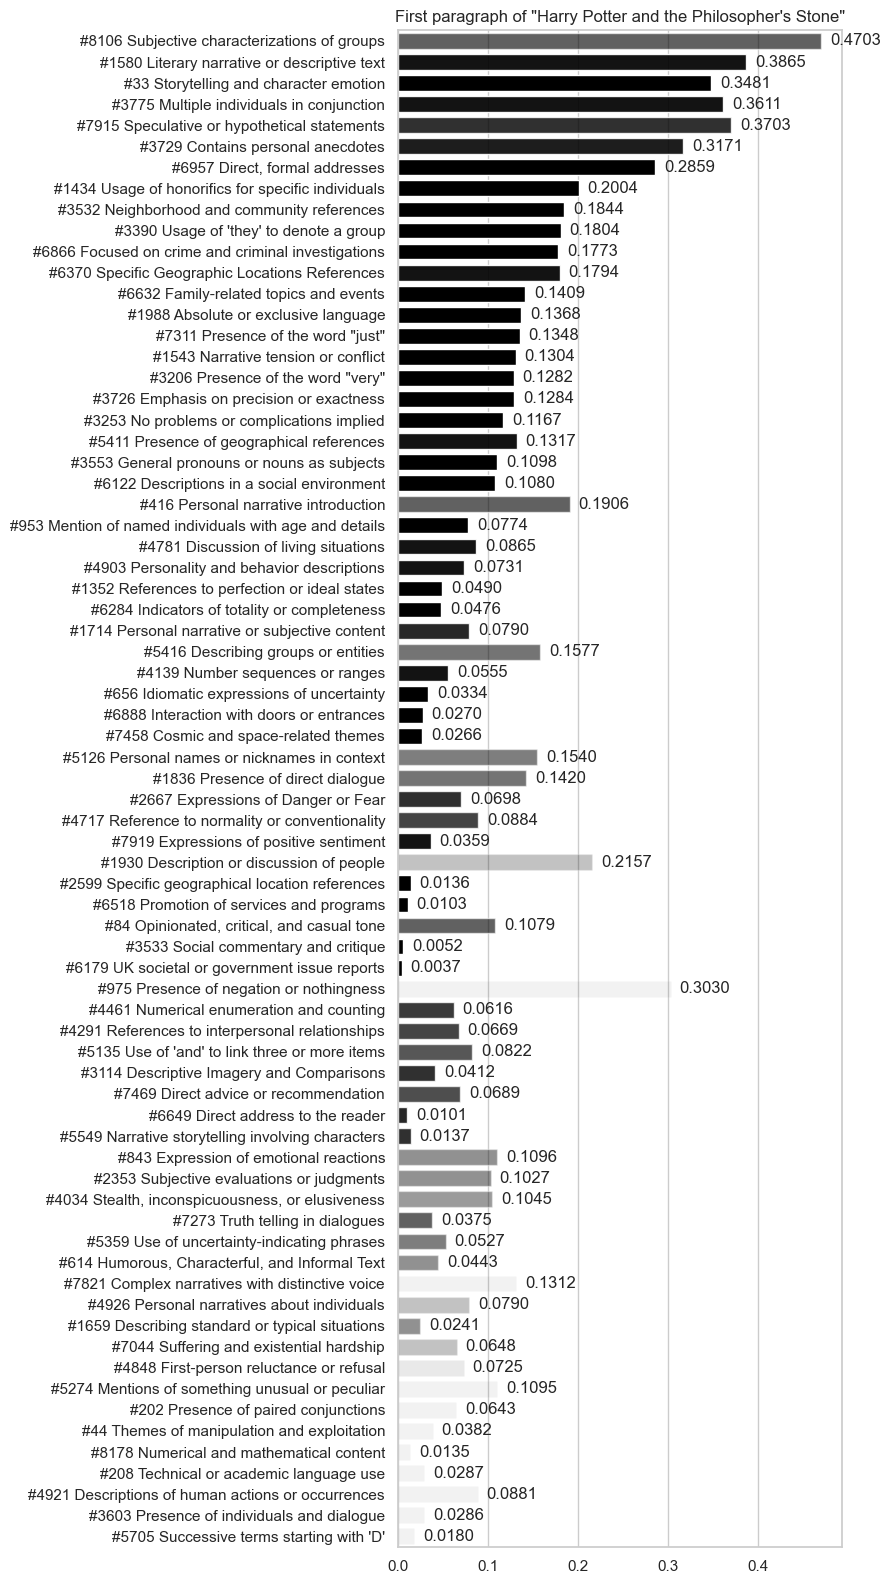

In [93]:
plot(
    get_text_features(
        """Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.""",
    ),
    title='First paragraph of "Harry Potter and the Philosopher\'s Stone"',
)

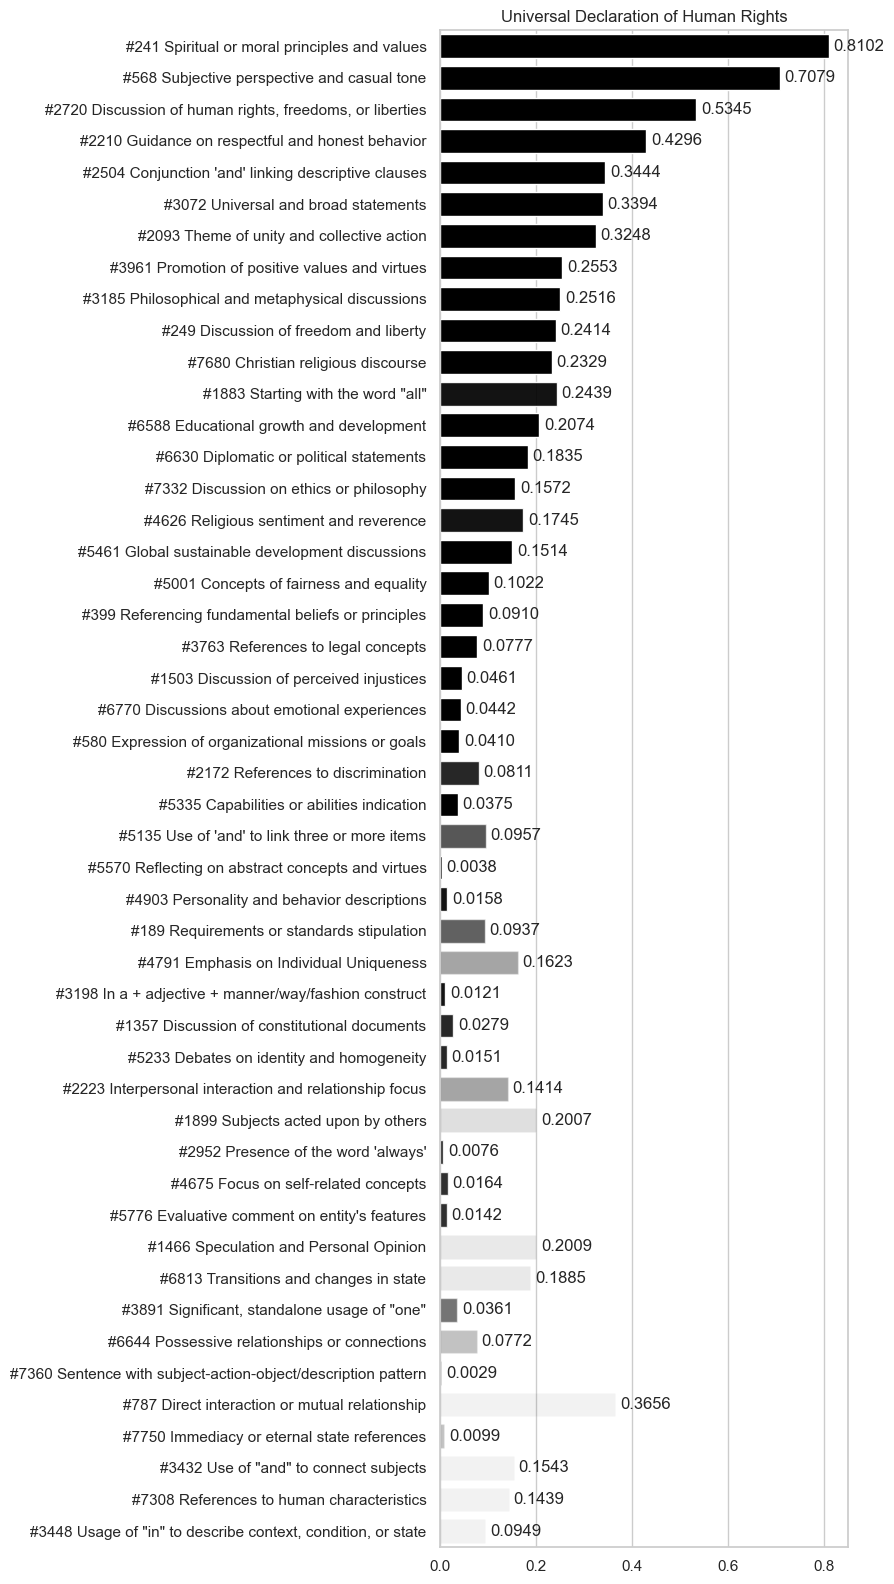

In [92]:
plot(
    get_text_features(
        "All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood."
    ),
    title="Universal Declaration of Human Rights",
)